# Simulating SC/KA Lennard-Jones with rumdpy 

Features included:
- cooling ramp giving insight into phase behavior
- lin-saving of scalars ('energies') within blocks
- log2-saving of configurations within blocks
- on-the-fly 3D visualization

In [1]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks    
#
# Timestep:                                        200_000                2_000_000
# Rumd3  GTX TITAN,        4.5 TFlops, 288 GB/s, runtime: 56   sec        196   sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# Rumd3  RTX 2080 Ti,     11.7 TFlops, 616 GB/s, runtime: 38.9 sec         77.8 sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# rumdpy RTX 3070 Laptop, 11.4 TFlops, 448 GB/s, runtime: 10.0 sec (256k)  39.9 sec (1000 conf_blocks * 257/167z Kb)  on-the-fly     ~1s 

## Imports

In [2]:
import numpy as np
import numba
import math

# rumdpy
import rumdpy as rp

# IO
import pandas as pd
import pickle
import sys
import h5py

# Plotting and visualization
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

import k3d
from k3d.colormaps import matplotlib_color_maps
import ipywidgets as widgets

## Generate configuration with a FCC lattice

In [3]:
include_KABLJ = True

c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=16,  ny=4,  nz=4,  rho=0.60,  T=3.44)    # N = 4*18*6*6 = 2592

if include_KABLJ:
    c1.ptype[np.arange(0,c1.N,5)] = 1    # 4:1 mixture

print(f'Number of particles: {c1.N}; Density: {c1.N/np.prod(c1.simbox.data):.3f}; B fraction: {np.mean(c1.ptype==1):.3f}')
c1.copy_to_device() 

# Get a 'compute-plan', i.e. parameters determining how simulations are performed on the GPU
# (to facilitate implementation of an auto-tuner, the choice of these parameters should be delayed to just before simulation)
compute_plan = rp.get_default_compute_plan(c1)
print('compute_plan:', compute_plan)

Number of particles: 864; Density: 0.600; B fraction: 0.200
compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}


## Setup Lennard-Jones pair potential

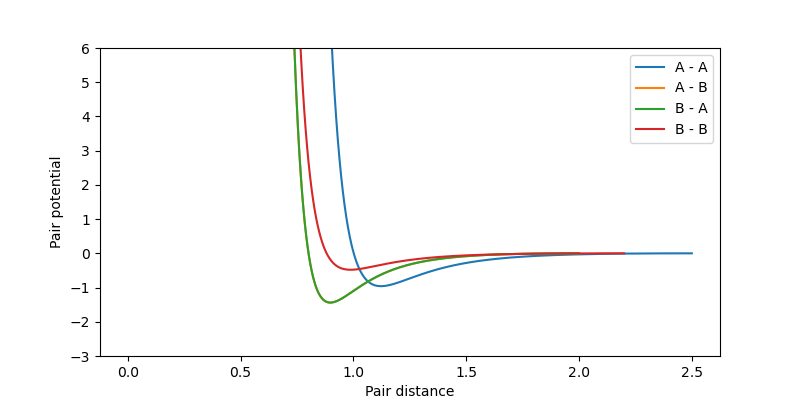

In [4]:
potential_function = rp.apply_shifted_force_cutoff(rp.make_LJ_m_n(12,6))
sigma =   [[1.00, 0.80], # Setting up KABLJ. If all particles are type 0, 
           [0.80, 0.88]] # ... this reverts to single component LJ
epsilon = [[1.00, 1.50], 
           [1.50, 0.50]] 
cutoff = np.array(sigma)*2.5
params = rp.LJ_12_6_params_from_sigma_epsilon_cutoff(sigma, epsilon, cutoff)
LJ = rp.PairPotential(c1, potential_function, params=params, max_num_nbs=1000, compute_plan=compute_plan)
pairs = LJ.get_interactions(c1, exclusions=None, compute_plan=compute_plan, verbose=False)
LJ.plot(names=['A', 'B'])

## Setup output managers

In [13]:
# Should be more elegant - and more flexible (move to simulation class?)

steps_between_output = 16
output_calculator = rp.make_scalar_calculator(c1, steps_between_output, compute_plan)

conf_saver = rp.make_conf_saver(c1, compute_plan)

include_rdf = True
if include_rdf:
    num_bins = 500
    full_range=True
    gr_bins_zeros = np.zeros(num_bins, dtype=np.float64) # float64 good / necessary ?
    d_gr_bins = numba.cuda.to_device(gr_bins_zeros)
       
    rdf_calculator = rp.make_rdf_calculator(c1, pair_potential = LJ, compute_plan=compute_plan, full_range=full_range, verbose=True)  

## Setup integrator

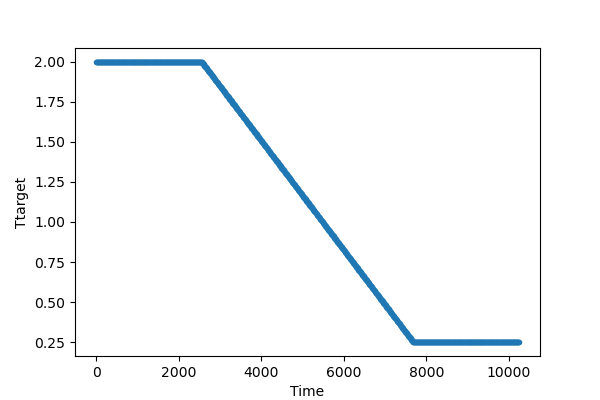

In [7]:
dt = 0.005 # timestep 
num_blocks = 1000         # Do simulation in this many 'blocks'
steps_per_block = 2*1024  # ... each of this many steps
running_time = dt*num_blocks*steps_per_block

Thigh = 2.00
Tlow  = 0.25
Ttarget_function = rp.make_function_ramp(value0=Thigh, x0=running_time*(1/4), value1=Tlow, x1=running_time*(3/4))

integrator = rp.integrators.nvt.setup_output(c1, pairs['interactions'], output_calculator, conf_saver, Ttarget_function, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False)

t = np.linspace(0,running_time,num_blocks)
T = numba.vectorize(Ttarget_function)(t)
plt.figure(figsize=(6,4))
plt.plot(t, T, '.-')
plt.xlabel('Time')
plt.ylabel('Ttarget')
plt.show()

## Run simulation

In [8]:
sim = rp.simulation(c1, integrator, dt, pairs, num_blocks, steps_per_block, steps_per_block, include_rdf=False, storage='memory')

Configurations per block (log2-storing): 13
Storing results in memory. Expected footprint 257.08 MB.


Start by running only part of the simulation. Usefull for testing/benchmark etc.:

In [9]:
for block in sim.run(num_blocks=200):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 100 125 150 175 
steps : 409600
nbflag :  [    0     0 44570]
time : 9.216392578125 s
TPS :  44442.55130496294


In [10]:
for block in sim.run(num_blocks=200):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 100 125 150 175 
steps : 409600
nbflag :  [    0     0 89138]
time : 7.470806640625 s
TPS :  54826.74357714783


The difference (~1.5 second) is the time taken on first run to do just-in-time (JIT) compilation to the GPU.

In [11]:
sim = rp.simulation(c1, integrator, dt, pairs, num_blocks, steps_per_block, steps_between_output, include_rdf=False, storage='hdf5', filename='output')

Configurations per block (log2-storing): 13
Saving results in hdf5 format. Filename: output.h5


In [12]:
for block in sim.run(num_blocks=200):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 100 125 150 175 
steps : 409600
nbflag :  [     0      0 133627]
time : 7.69417529296875 s
TPS :  53235.07515799765


## Initialize 3D visualization

In [13]:
plt_points = k3d.points(positions=c1['r'],
                        point_sizes=np.ones((c1.N),dtype=np.float32),
                        #shader='3dSpecular',
                        #shader='3d',
                        shader='mesh',
                        color_map=matplotlib_color_maps.Jet,
                        attribute=c1.scalars[:,0],
                        color_range=[-6, 0],
                        name='Atoms'
                       )
Lx, Ly, Lz = c1.simbox.data
plt_box = k3d.lines(vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                              [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                              [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                              [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]], 
                    indices=[[0,1], [0,2], [0,3], 
                            [1,4], [1,5], [2,4], [2,6], [3,5], [3,6],
                            [7,4], [7,5], [7,6]], 
                    indices_type='segment',
                    shader='mesh', width=min((Lx, Ly, Lz))/100, 
                    name='Simulation Box'
                   )


plt_time_text = k3d.text2d('Time: ', position=[0.01, 0.15], is_html=True)
plt_temp_text = k3d.text2d('Temperature: ', position=[0.01, 0.25], is_html=True,)
plt_fn_text = k3d.text2d('Potential:', position=[0.01, 0.42], is_html=True)

plot = k3d.plot(camera_mode='orbit', camera_fov=3.0,)
plot += plt_points
plot += plt_box
plot += plt_fn_text + plt_time_text + plt_temp_text
#plot.display()

In [31]:
def update_3D(index, choice):
    plt_points.positions = conf_list[index]
    model_time = (index+1)*dt*steps_per_block
    plt_time_text.text = f'Time: {model_time:.2f}'
    plt_temp_text.text = f'Temp: {Ttarget_function(model_time):.3f}'
    if choice==6:
        plt_points.attribute = c1.ptype
    else:
        plt_points.attribute = scalars_list[index][:,choice]
    Lx, Ly, Lz = c1.simbox.data
    plt_box.vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                      [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                      [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                      [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]],
    
def set_color_range(choice):
    labels = {0:'Potential:', 1:'Virial:', 2:'Laplace U:', 3:'m:', 4:'Kinetic nrg:', 5:'F^2', 6:'Type'}
    plt_fn_text.text = labels[choice]
    if choice == 6:
        minval, maxval = np.min(c1.ptype), np.max(c1.ptype)
    else:
        minval, maxval = np.percentile(scalars_list[:,:,choice], (1, 99))
    if minval==maxval:
        minval -= abs(minval*.1)
        maxval += abs(maxval*.1)
    plt_points.color_range = (minval, maxval)
        
play = widgets.Play(
    value=num_blocks-1,
    min=0,
    max=num_blocks-1,
    step=1,
    interval=0,
    description="Press play",
    disabled=False
)

attribute_dropdown = widgets.Dropdown(
    options=[('Potential energy', 0), ('Virial', 1), ('Laplace U', 2), ('m', 3), ('Kinetic energy', 4), ('F^2', 5), ('Type', 6)],
    value=0,
    description='Color:',
    disabled=False,
)

slider = widgets.IntSlider(description='Frame:', max=play.max)
widgets.jslink((play, 'value'), (slider, 'value'))

w0 = widgets.interactive(update_3D, index=play, choice=attribute_dropdown)
w1 = widgets.interactive(set_color_range, choice=attribute_dropdown)

## Scale configuration to desired density 

In [32]:
%%time

# Scale to desired density
target_density = 0.65
c1.copy_to_host()
current_density = c1.N/np.prod(c1.simbox.data)
scale_factor = (current_density/target_density)**(1/3)
c1['r'] *= scale_factor
c1.simbox.data *= scale_factor
c1.copy_to_device()

CPU times: user 5.46 ms, sys: 12.6 ms, total: 18.1 ms
Wall time: 15.3 ms


## Run Simulation 

In [37]:
def run(num_blocks):
    # Inializing run
    # Store simulation parameters for use in post run analysis
    #sim_params = {'N':c1.N, 'D':c1.D, 'simbox':c1.simbox.data, 'integrator':integrator, 'rdf':include_rdf}
    #print('sim_params:', sim_params)
    #with open('Data/LJ_pdict.pkl', 'wb') as f:
    #    pickle.dump(sim_params, f)

    num_conf = round(math.log2(steps_per_block)+2)
    print('num_conf:', num_conf)
    zero_conf_array = np.zeros((num_conf, 2, c1.N, c1.D), dtype=np.float32)
    d_conf_array = cuda.to_device(zero_conf_array)

    zero_output_array = np.zeros((steps_per_block//steps_between_output, 5), dtype=np.float32)
    d_output_array = cuda.to_device(zero_output_array) 
    d_gr_bins = cuda.to_device(gr_bins_zeros)

    # "Equilibrate"
    #integrate0(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  
    #       pairs['interaction_params'], integrator_params0, d_output_array, d_conf_array, np.float32(0), inner_steps)

#    scalars_t = []
    tt = []
    #vol_t = []
    conf_list = []
#    scalars_list = []
#    gr_bins = [] 

    start = cuda.event()
    end = cuda.event()
    zero = np.float32(0.0)

    start.record() 
    
    for block in range(num_blocks):
        d_output_array = cuda.to_device(zero_output_array) # Set output array to zero. Could probably be done faste
        d_conf_array = cuda.to_device(zero_conf_array) # not needed every block, since should overwrite
        integrator[0](c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  pairs['interaction_params'], integrator[1], d_output_array, d_conf_array, np.float32(block*steps_per_block*dt), steps_per_block)
        
        scalars_t.append(d_output_array.copy_to_host())        
        
        #if memory_blocks or hdf5_blocks or hdf5virtual_blocks:
        #    block_array = d_conf_array.copy_to_host()
            
        #if memory_blocks:
        #    conf_blocks[block] = block_array
            
        #if hdf5_blocks:
        #    with h5py.File(f"Data/LJ_trajectory.h5", "a") as f:
        #        f['block'][block,:] = block_array
                
        #if hdf5virtual_blocks:
        #    with h5py.File(f"Data/LJ_trajectory/conf_block_{block:05d}.h5", "w") as f:
        #        f.create_dataset("block", (conf_per_block, num_vectors, c1.N, c1.D,), "float32", block_array)
        
        vol = (c1.simbox.data[0] * c1.simbox.data[1] * c1.simbox.data[2])
        vol_t.append(vol)

        if include_rdf:
            rdf_calculator(c1.d_vectors, c1.simbox.d_data, c1.d_ptype, pairs['interaction_params'], d_gr_bins)
            gr_bins.append(d_gr_bins.copy_to_host())
            d_gr_bins = cuda.to_device(gr_bins_zeros)

        yield block
    
    # Finalizing run
    end.record()
    end.synchronize()
    timing_numba = cuda.event_elapsed_time(start, end)
    nbflag = LJ.nblist.d_nbflag.copy_to_host()    
    tps = num_blocks*steps_per_block/timing_numba*1000
    output_array = d_output_array.copy_to_host()
    #scalars_list = np.array(scalars_list)
    
    print('\tsteps :', num_blocks*steps_per_block)
    print('\tnbflag : ', nbflag)
    print('\ttime :', timing_numba/1000, 's')
    print('\tTPS : ', tps )
    print('\tfinal box dims : ', c1.simbox.data[0], c1.simbox.data[1], c1.simbox.data[2])

In [38]:
conf_list = []
scalars_list = []
scalars_t = []
vol_t = []
gr_bins = [] 
    
plt_points.color_range=[-6, 0]
plot.display()

for block in run(num_blocks):
    # Update 3D visualizaton
    c1.copy_to_host()
    conf_list.append(c1['r'])
    scalars_list.append(c1.scalars)
    update_3D(block, 0)

scalars_list = np.array(scalars_list)       
display(widgets.HBox([play, slider, attribute_dropdown]))

 

Output()

num_conf: 13
	steps : 2048000
	nbflag :  [     0      0 549394]
	time : 43.08623046875 s
	TPS :  47532.58704043264
	final box dims :  10.995124 10.995124 10.995124


In [23]:
plt_points.point_sizes = 2.

In [40]:
plt_fn_text.text = 'u'
attribute = c1.scalars[:,0]
print(np.mean(attribute), np.std(attribute), min(attribute), max(attribute))
plt_points.attribute = attribute
plt_points.color_range=[min(attribute), max(attribute)]

-6.1891255 1.2657802 -9.374435 -2.80755


## Write results to disc

In [25]:
if type(scalars_t) == list:
    scalars_t = np.concatenate(scalars_t)

# Save data
df = pd.DataFrame(scalars_t, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)
df['t'] = np.array(np.arange(scalars_t.shape[0])*dt*steps_between_output, dtype=np.float32)
df['vol'] = vol_t[0]
if integrator[0:3]!='NVE':
    df['Ttarget'] = numba.vectorize(T1)(np.array(df['t']))
if integrator=='NPT_Langevin':
    df['Ptarget'] = numba.vectorize(P0)(np.array(df['t'])) 
df.to_csv('Data/LJ_scalars.csv', index=False)


In [26]:
if include_rdf:
    if type(gr_bins) == list:
         gr_bins = np.array(gr_bins)
         data = rp.normalize_and_save_gr_multi(gr_bins, c1, pairs['interaction_params'], full_range, filename='Data/LJ_rdf.dat')

10.995124
0.6500000275505925 0.010995123863220215


In [27]:
scalars_t

array([[-2.47653589e+03,  1.10743018e+03,  6.05241750e+05,
         1.32263575e+06,  2.53309644e+03],
       [-2.55635400e+03,  7.80397888e+02,  5.76372938e+05,
         1.03977825e+06,  2.66684863e+03],
       [-2.53501392e+03,  8.58367432e+02,  5.77962125e+05,
         1.02405244e+06,  2.51434399e+03],
       ...,
       [-5.42220020e+03, -4.07456207e+02,  8.48716062e+05,
         2.14391750e+05,  3.03561523e+02],
       [-5.42417090e+03, -4.21717438e+02,  8.45587812e+05,
         2.15036094e+05,  3.36889648e+02],
       [-5.43536816e+03, -5.88777893e+02,  8.28098312e+05,
         1.98437406e+05,  3.08399628e+02]], dtype=float32)

In [28]:
%%time 
np.save('Data/LJ_scalars.npy', scalars_t)

CPU times: user 0 ns, sys: 1.85 ms, total: 1.85 ms
Wall time: 1.69 ms


In [29]:
%%time 
scalars_t.shape
dfn = np.load('Data/LJ_scalars.npy')
df = pd.DataFrame(dfn, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)

CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.53 ms


In [30]:
%%time
#!rm Data/LJ_scalars_.h5
with h5py.File('Data/LJ_scalars_.h5', 'w') as f:
    f['scalars'] = scalars_t[:,:]
    f['vectors'] = c1.vectors.array

CPU times: user 0 ns, sys: 2.86 ms, total: 2.86 ms
Wall time: 2.72 ms


In [31]:
%%time
f = h5py.File('Data/LJ_scalars_.h5', 'r')
x = np.array(f['scalars'])
C = np.array(f['vectors'])

CPU times: user 4.78 ms, sys: 0 ns, total: 4.78 ms
Wall time: 4.56 ms


## Data analysis

Only using data stored on disc, i.e. the following could/should be separated into its own notebook

In [32]:
import numpy as np
import rumdpy as rp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

u           -3643.187028
w             -25.930150
lap        638613.573361
fsq        646587.462382
k            1456.266929
t            5119.960000
vol          1329.230700
Ttarget         1.125007
dtype: float64


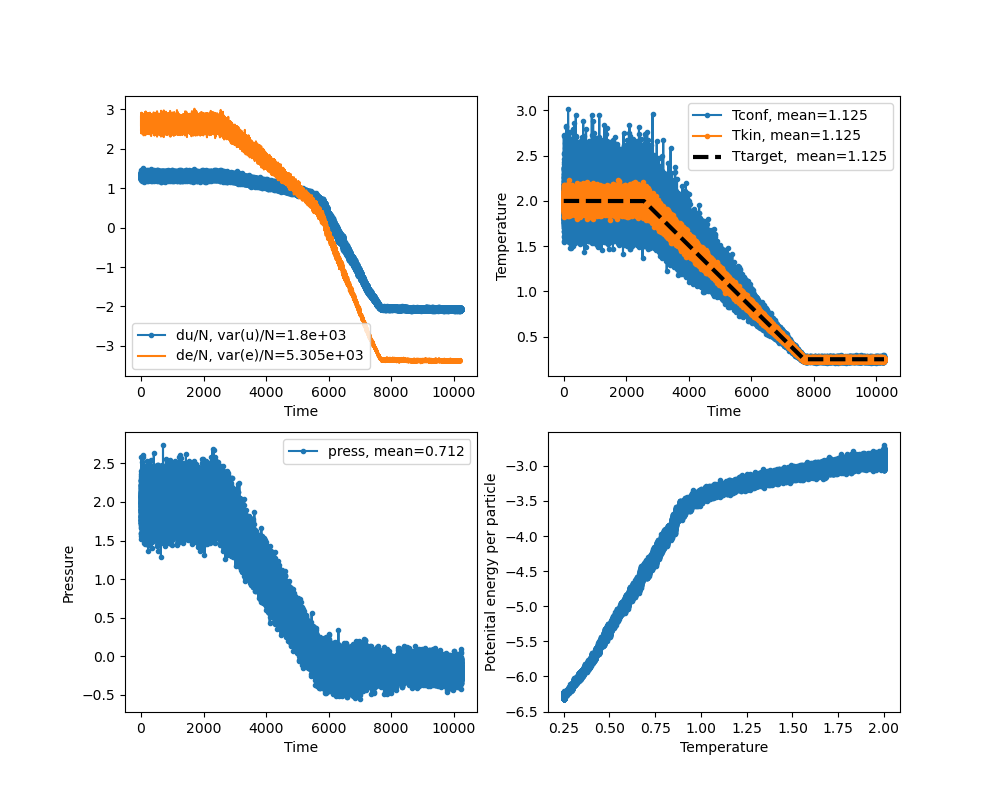

In [33]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)
df = pd.read_csv('Data/LJ_scalars.csv', index_col=False)
#print(df)
print(df.mean())
rp.plot_scalars(df, pdict['N'],  pdict['D'], figsize=(10,8), block=True)

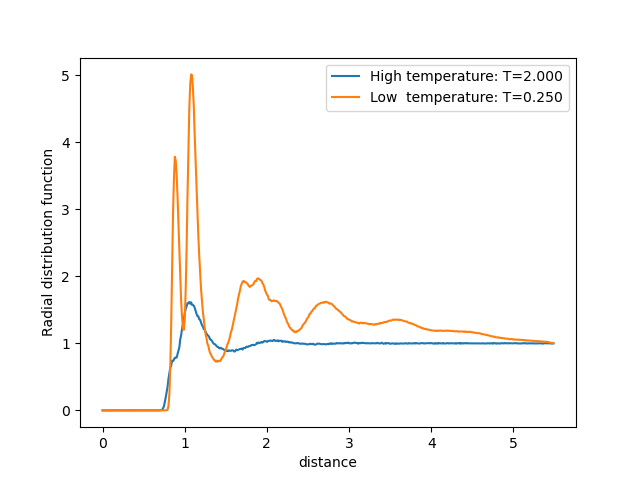

In [34]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)

if pdict['rdf']:
    rdf = np.loadtxt('Data/LJ_rdf.dat')
    plt.figure()
    plt.plot(rdf[:,0], np.mean(rdf[:, 50: 250], axis=1), label=f'High temperature: T={Thigh:.3f}')
    plt.plot(rdf[:,0], np.mean(rdf[:,800:1000], axis=1), label=f'Low  temperature: T={Tlow:.3f}')
    plt.xlabel('distance')
    plt.ylabel('Radial distribution function')
    plt.legend()
    plt.show(block=False)

In [35]:
def calc_dynamics_(conf, conf_array, block0, conf_index0, block1, conf_index1, time_index, msd, m4d):
    dR =   conf_array[block1,conf_index1,0,:,:] - conf_array[block0,conf_index0,0,:,:]
    dR += (conf_array[block1,conf_index1,1,:,:] - conf_array[block0,conf_index0,1,:,:])*conf.simbox.data
    for i in range(np.max(conf.ptype) + 1):
        msd[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1))
        m4d[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1)**2)

    return msd, m4d

def calc_dynamics(conf, conf_array, dt):
    
    num_types = np.max(conf.ptype) + 1
    num_blocks, conf_per_block = conf_array.shape[0:2]
    extra_times = int(math.log2(num_blocks))
    total_times = conf_per_block-1 + extra_times
    count = np.zeros((total_times,1), dtype=np.int32)
    msd = np.zeros((total_times, num_types))
    m4d = np.zeros((total_times, num_types))
    
    times = dt*2**np.arange(total_times)
    
    for block in range(0, num_blocks):
        for i in range(conf_per_block-1):
            count[i] += 1
            calc_dynamics_(conf, conf_array, block, i+1, block, 0, i, msd, m4d)
            
    # Compute times longer than blocks
    for block in range(0, num_blocks):
        for i in range(extra_times):
            index = conf_per_block-1 + i 
            other_block = block + 2**(i+1)            
            if other_block < num_blocks:
                count[index] += 1
                calc_dynamics_(conf, conf_array, other_block, 0, block, 0, index, msd, m4d)
 
    msd /= count
    m4d /= count
    alpha2 = 3*m4d/(5*msd**2) - 1 
    return {'times':times, 'msd':msd, 'alpha2':alpha2, 'count':count}

In [36]:
%%time
if memory_blocks:
    print(f'conf_blocks: {conf_blocks.shape}, {conf_blocks.nbytes/1024/1024:.2f} MB')
    dyn_high = calc_dynamics(c1, conf_blocks[ 50:250], dt) 
    dyn_low  = calc_dynamics(c1, conf_blocks[800:999], dt)

conf_blocks: (1000, 13, 2, 864, 3), 257.08 MB
CPU times: user 861 ms, sys: 1.28 ms, total: 863 ms
Wall time: 862 ms


In [37]:
%%time
if hdf5_blocks:
    with h5py.File("Data/LJ_trajectory.h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 1.23 s, sys: 39 ms, total: 1.27 s
Wall time: 1.26 s


In [38]:
%%time
if sim.storage=='hdf5':
    with h5py.File(sim.filename+".h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [39]:
%%time
if hdf5virtual_blocks:
    with h5py.File("Data/LJ_trajectory_vir.h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 1.77 s, sys: 82.8 ms, total: 1.85 s
Wall time: 1.9 s


In [40]:
print(dyn_high.keys())
dyn_high['count'].T

dict_keys(['times', 'msd', 'alpha2', 'count'])


array([[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 198,
        196, 192, 184, 168, 136,  72]], dtype=int32)

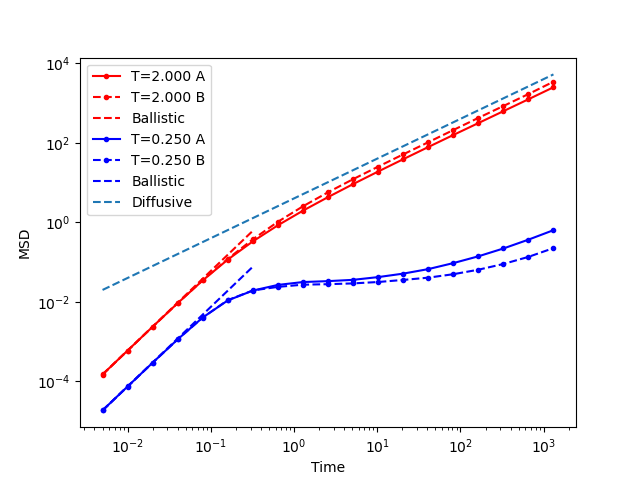

In [43]:
plt.figure()
num_types = dyn_high['msd'].shape[1]
plt.loglog(dyn_high['times'], dyn_high['msd'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.loglog(dyn_high['times'], dyn_high['msd'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.loglog(dyn_high['times'][:7], 3*Thigh*dyn_high['times'][:7]**2, 'r--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['msd'][:,0], 'b.-', label=f'T={Tlow:.3f} A')
if num_types>0:
       plt.loglog(dyn_low['times'], dyn_low['msd'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.loglog(dyn_low['times'][:7], 3*Tlow*dyn_low['times'][:7]**2, 'b--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['times']*4, '--', label='Diffusive')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.legend()
plt.show()

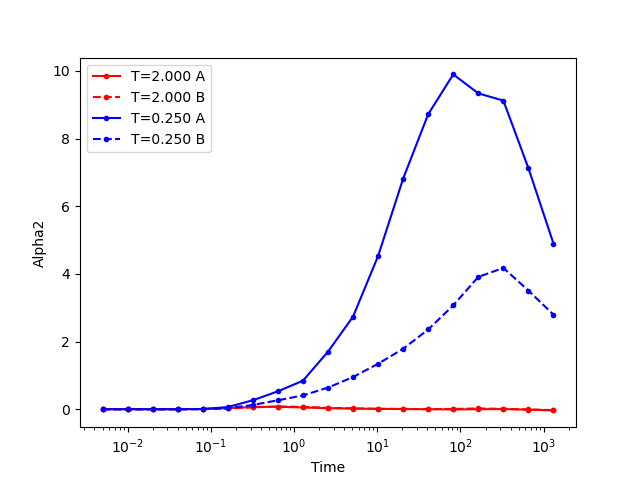

In [42]:
plt.figure()
plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,0], 'b.-', label=f'T={Tlow:.3f} A') 
if num_types>0:
    plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.xlabel('Time')
plt.ylabel('Alpha2')
plt.legend()
plt.show()